In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance
from scipy.stats import wasserstein_distance

from preprocess.acf import *
from preprocess.gaussianize import *

from arch import arch_model

/var/folders/zm/2skfb_551w7gvzm_p11vjq7h0000gn/T/ipykernel_17385/2058876387.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(file_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)


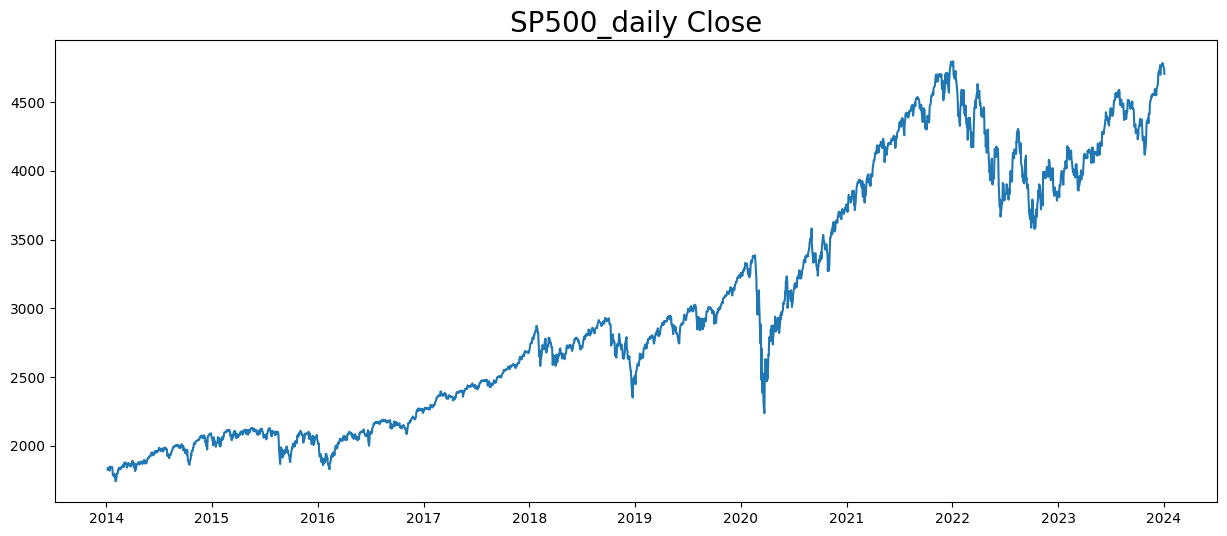

In [2]:
file_name = "SP500_daily"
file_path = "data/"+file_name+".csv"
generator_path = ""


def dateparse(d):
    return pd.Timestamp(d)

data = pd.read_csv(file_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)
df = data['Close']
fig = plt.figure(figsize=(15,6))
plt.title(f'{file_name} Close', fontsize=20)
plt.plot(data['datetime'], data['Close'] )
plt.show()
# confirm data loaded

## Preprocess data
 For more details see [preprocess.ipynb](./preprocess.ipynb)

In [3]:
returns = df.shift(1)/df - 1
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
receptive_field_size = 127  # p. 17
log_returns_rolled = rolling_window(log_returns_preprocessed, receptive_field_size)
data_size = log_returns.shape[0]
print(data_size)

2515


## Train model

In [4]:

model = arch_model(log_returns, vol='Garch', p=1, q=1)
result = model.fit()
mean = log_returns.mean()
volatilities = result.conditional_volatility

num_paths = 400

garch_returns = np.empty((num_paths, len(volatilities)+1))
garch_returns[:, 0] = log_returns[0]  # Initialize each path with the first log return

# Generate all random innovations at once
innovations = np.random.normal(mean, volatilities, size=(num_paths, len(volatilities)))

# Add innovations to log returns to compute garch_returns
garch_returns[:, 1:] = innovations

y = garch_returns

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.239121775658212e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2.82564325857482e+17
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8381.483841041005
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8381.483833018487
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3


/Users/shalomguslits/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001257. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


## Generate

Text(0, 0.5, 'Cumalative Log Return')

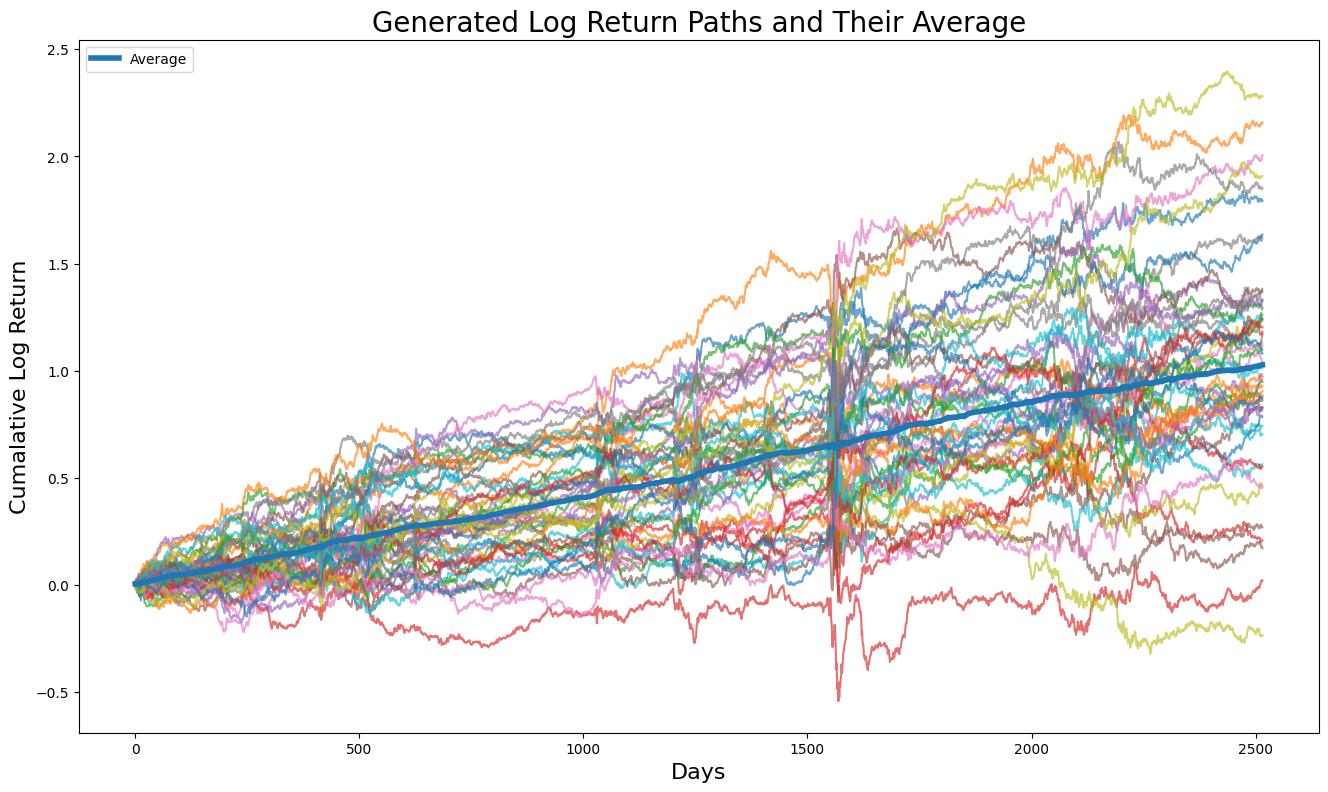

In [20]:
ySum = y[0:100].cumsum(axis=1).mean(axis=0)

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(ySum, alpha=1, lw = 4, zorder = 2)
ax.plot(np.cumsum(y[0:50], axis=1).T, alpha=0.65, zorder = 1)
ax.legend(['Average'])

ax.set_title('Generated Log Return Paths and Their Average'.format(len(y)), fontsize=20)
ax.set_xlabel('Days', fontsize=16)
ax.set_ylabel('Cumalative Log Return', fontsize=16)

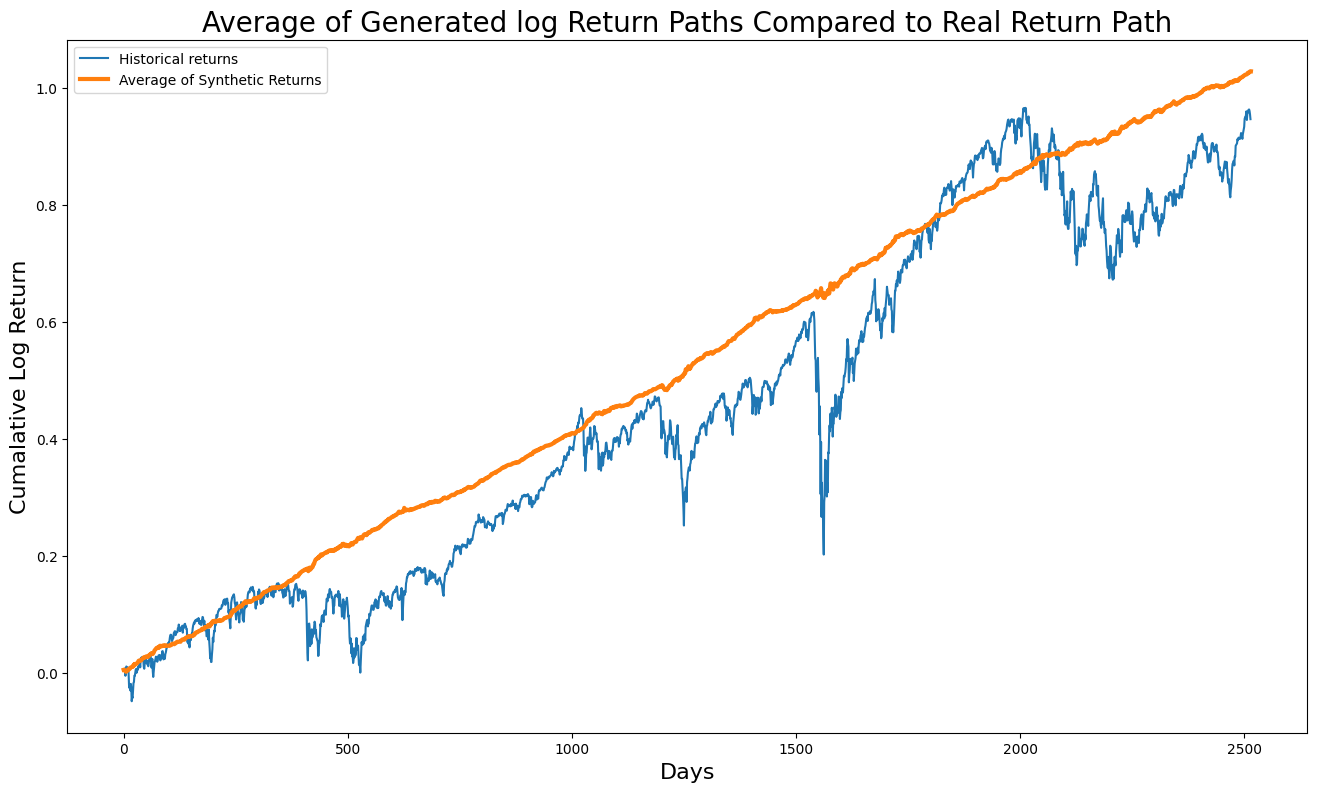

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(log_returns, axis=0))
ax.set_title('Average of Generated log Return Paths Compared to Real Return Path'.format(len(y)), fontsize=20)
ax.set_xlabel('Days', fontsize=16)
ax.set_ylabel('Cumalative Log Return', fontsize=16)

#for i in [105, 150, 200]:
#    ax.plot(y[100:i].cumsum(axis=1).mean(axis=0))
ax.plot(ySum, alpha=1, lw = 3)

ax.legend(['Historical returns', 'Average of Synthetic Returns'])


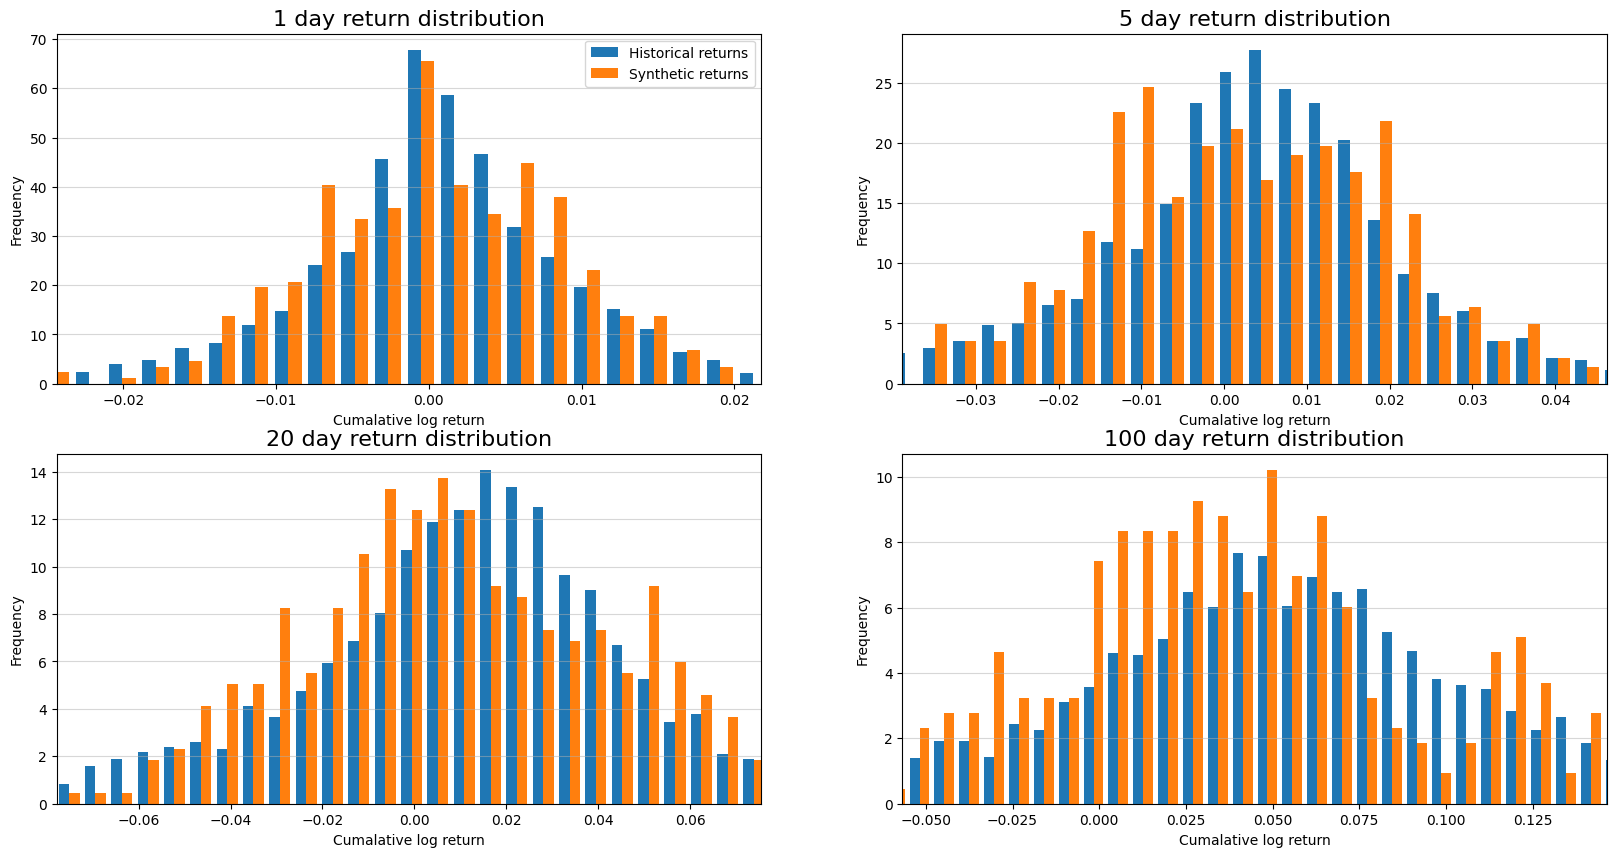

In [22]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T[1][:], windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=100, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])



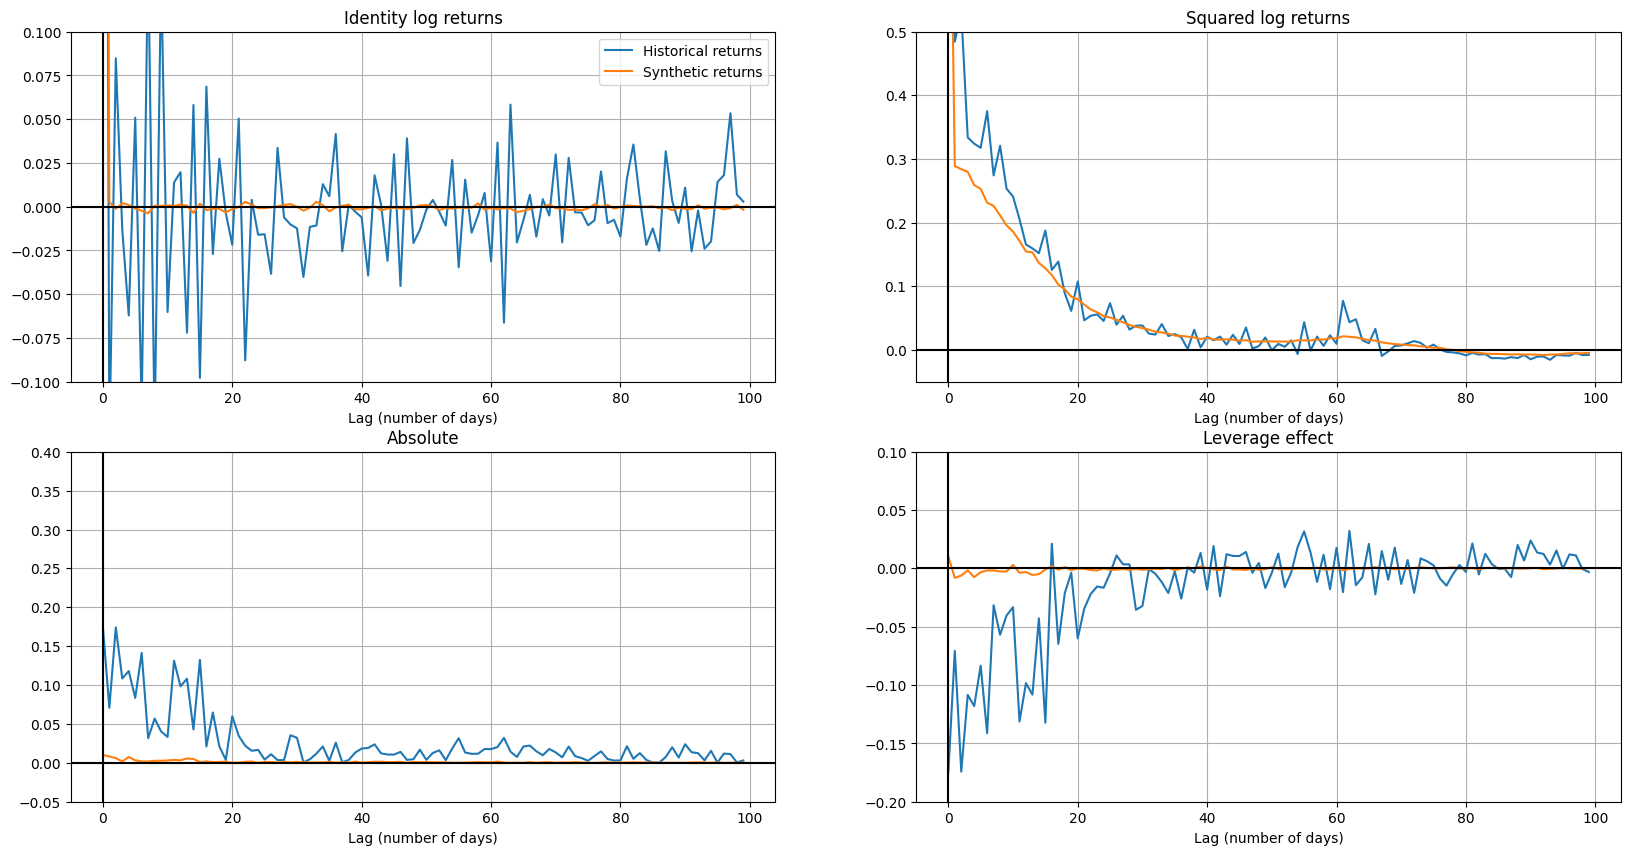

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days)')
axs[0,0].legend(['Historical returns', 'Synthetic returns'])

In [27]:
# Wass Distance
wass_avg = 0

print(len(log_returns.transpose()[0]))
for i in range(len(y)):
    wass_avg += wasserstein_distance(y[i,:], log_returns.transpose()[0])
wass_avg /= len(y)

print("Average Wasserstein Distance: " + str(wass_avg))

# JS-Divergence
r_data = []
for data_point in log_returns:
	r_data.append(data_point[0])
real_data = np.array(r_data)
real_histogram = np.histogram(real_data, bins=int(len(real_data)/10), density=True)

divergences = []

for return_path in y:
	hist = np.histogram(return_path, bins=int(len(real_data)/10), density=True)
	divergences.append(distance.jensenshannon(real_histogram[0], hist[0], 2.0))

avg_divergence = np.mean(np.array(divergences))
print("Average JS-Divergence: " + str(avg_divergence))

2515
Average Wasserstein Distance: 0.0007393898851214991
Average JS-Divergence: 0.6879939632988332
